# Home Energy Management

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import calendar
import tqdm

# Custom utility functions
from utils import latexify

# Define the golden mean for plotting
golden_mean = (np.sqrt(5) - 1.0) / 2.0 

## Problem data

In [2]:
# Historical load and price data
load_data = pd.read_pickle("data/load_data.pickle")
load_min = load_data.min()
load_max = load_data.max()
tou_price_data = pd.read_pickle("data/tou_price_data.pickle")
spot_price_data = pd.read_pickle("data/spot_price_data.pickle")

# Load data for load forecasting
load_baseline = pd.read_pickle("data/load_baseline.pickle")
train_residual = pd.read_pickle("data/train_residual.pickle")
AR_params = pd.read_pickle("data/AR_params.pickle")

# Define the simulation window: one year (365 days) with hourly resolution
T = 24 * 365
start_date = pd.Timestamp("2022-01-01 00:00:00")

# Find the starting and ending time indices for the simulation window in load_data
sim_start_time = load_baseline.index.get_loc(start_date)
sim_end_time = sim_start_time + T

# Extract the DateTimeIndex corresponding to the simulation window
sim_index = load_data.index[sim_start_time:sim_end_time]

# Load and price data for the simulation window
l = load_data.iloc[sim_start_time:sim_end_time].values
tou_prices = tou_price_data.iloc[sim_start_time:sim_end_time].values
spot_prices = spot_price_data.iloc[sim_start_time:sim_end_time].values

# Constants for calculating the linear peak cost
a = 83
b = 20.35

## Simulation without storage

In [3]:
def compute_monthly_tou_cost(tou_prices, power, sim_index):
    monthly_tou_cost = []
    for k in range(12):
        month_mask = (sim_index.month == k + 1)
        month_cost = np.sum(tou_prices[month_mask] * power[month_mask])
        monthly_tou_cost.append(month_cost)
    return monthly_tou_cost

def compute_monthly_spot_cost(spot_prices, power, sim_index):
    monthly_spot_cost = []
    for k in range(12):
        month_mask = (sim_index.month == k + 1)
        month_cost = np.sum(spot_prices[month_mask] * power[month_mask])
        monthly_spot_cost.append(month_cost)
    return monthly_spot_cost

def compute_monthly_peak_power_cost(power, sim_index):
    def tiered_cost(z):
        if 0 <= z <= 2:
            return 83
        elif 2 < z <= 5:
            return 147
        elif 5 < z <= 10:
            return 252
        elif 10 < z <= 15:
            return 371
        else:
            return 490

    monthly_peak_power_cost = []
    for k in range(12):
        month_mask = sim_index.month == k + 1
        month_length = sum(month_mask)
        daily_peak_powers = [power[month_mask][i:i+24].max() for i in range(0, month_length, 24)]
        top_3_daily_peaks = sorted(daily_peak_powers, reverse=True)[:3]
        average_top_3_peaks = sum(top_3_daily_peaks) / 3
        monthly_peak_power_cost.append(tiered_cost(average_top_3_peaks))
    return monthly_peak_power_cost

def compute_annual_cost(spot_prices, tou_prices, power, sim_index):
    monthly_tou_cost = compute_monthly_tou_cost(tou_prices, power, sim_index)
    monthly_spot_cost = compute_monthly_spot_cost(spot_prices, power, sim_index)
    monthly_peak_power_cost = compute_monthly_peak_power_cost(power, sim_index)
    
    annual_cost = sum(monthly_tou_cost) + sum(monthly_spot_cost) + sum(monthly_peak_power_cost)
    return annual_cost
    
def print_cost_summary(total_cost, spot_cost, tou_cost, peak_power_cost):
    print(f"Total cost for 2022: {total_cost:,.2f} NOK")
    print(f"Time-of-use cost: {tou_cost:,.2f} NOK ({100 * tou_cost / total_cost:.2f}% of total cost)")
    print(f"Spot market cost: {spot_cost:,.2f} NOK ({100 * spot_cost / total_cost:.2f}% of total cost)")
    print(f"Peak power cost: {peak_power_cost:,.2f} NOK ({100 * peak_power_cost / total_cost:.2f}% of total cost)")
    
# Compute z: monthly average of the largest 3 daily peak powers
def compute_z(power, sim_index):
    z_values = []
    for k in range(12):
        month_mask = (sim_index.month == k + 1)
        month_length = sum(month_mask)
        daily_peak_powers = [power[month_mask][i:i+24].max() for i in range(0, month_length, 24)]
        avg_top_3_peaks = sum(sorted(daily_peak_powers, reverse=True)[:3]) / 3
        z_values.extend([avg_top_3_peaks] * month_length)
    return pd.Series(z_values, index=sim_index)

def plot_and_save_monthly_costs(monthly_spot_cost, monthly_tou_cost, monthly_peak_power_cost, filename):
    months = range(1, 13)
    latexify(fig_width=6.5)
    plt.figure()
    plt.bar(months, monthly_tou_cost, label='Time-of-use cost')
    plt.bar(months, monthly_peak_power_cost, bottom=monthly_tou_cost, label='Peak power cost')
    plt.bar(months, monthly_spot_cost, bottom=[i+j for i,j in zip(monthly_tou_cost, monthly_peak_power_cost)], label='Spot market cost')
    plt.xticks(months, [calendar.month_abbr[m] for m in months])
    plt.xlabel('Month')
    plt.ylabel('Cost (NOK)')
    plt.legend()
    plt.savefig(filename)

def customize_monthly_x_axis(ax, interval):
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
def plot_and_save_grid_power(sim_index, power, filename):
    # Compute z: monthly average of the largest 3 daily peak powers
    z = compute_z(power, sim_index)
    
    latexify(fig_width=6.5)
    fig, ax = plt.subplots()
    ax.plot(sim_index, power, color="tab:blue", label="Power imported from the grid")
    ax.plot(sim_index, z, color="k", label="Monthly avg. of 3 daily peak powers")
    plt.ylabel("Power (kW)")
    customize_monthly_x_axis(ax, interval=1)
    legend = plt.legend()
    plt.savefig(filename)
    
def print_plot_and_save_costs(spot_prices, tou_prices, power, sim_index, filename):
    monthly_tou_cost = compute_monthly_tou_cost(tou_prices, power, sim_index)
    monthly_spot_cost = compute_monthly_spot_cost(spot_prices, power, sim_index)
    monthly_peak_power_cost = compute_monthly_peak_power_cost(power, sim_index)
    
    annual_cost = sum(monthly_tou_cost) + sum(monthly_spot_cost) + sum(monthly_peak_power_cost)
    annual_spot_cost = sum(monthly_spot_cost)
    annual_tou_cost = sum(monthly_tou_cost)
    annual_peak_power_cost = sum(monthly_peak_power_cost)
    
    print_cost_summary(annual_cost, annual_spot_cost, annual_tou_cost, annual_peak_power_cost)
    
    plot_and_save_monthly_costs(monthly_spot_cost, monthly_tou_cost, monthly_peak_power_cost, filename)

Total cost for 2022: 25,037.07 NOK
Time-of-use cost: 8,676.61 NOK (34.66% of total cost)
Spot market cost: 13,336.45 NOK (53.27% of total cost)
Peak power cost: 3,024.00 NOK (12.08% of total cost)


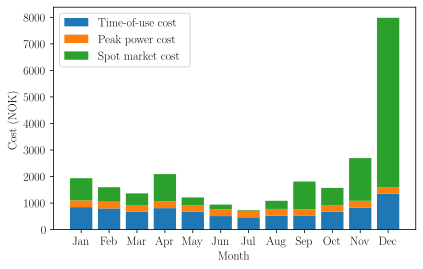

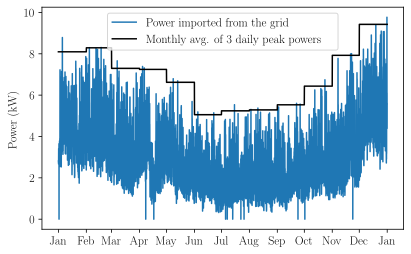

In [4]:
print_plot_and_save_costs(spot_prices, tou_prices, l, sim_index, "figures/monthly_costs_no_storage.pdf")
plot_and_save_grid_power(sim_index, l, "figures/grid_power_no_storage.pdf")
cost_no_storage = compute_annual_cost(spot_prices, tou_prices, l, sim_index)

## Prescient optimization (15 kWh of storage capacity)

In [5]:
# Constants
alpha = 0.01
P = 20

# Parameters
Q = cp.Parameter(nonneg=True, value=0)
C = cp.Parameter(nonneg=True, value=Q.value / 2)
D = cp.Parameter(nonneg=True, value=Q.value / 2)
q_init = cp.Parameter(nonneg=True, value=Q.value / 2)
q_final = cp.Parameter(nonneg=True, value=Q.value / 2)

# Variables
p = cp.Variable(T)  # Grid power
u = cp.Variable(T)  # Battery power
q = cp.Variable(T+1)  # State of charge

# Constraints
cons = [p >= 0, p <= P,
        l == p + u,
        q[1:] == (1 - alpha) * q[:-1] - u,
        q[0] == q_init, q[-1] == q_final,
        q >= 0, q <= Q,
        -C <= u, u <= D]

tou_cost = cp.sum(cp.multiply(tou_prices, p))
spot_cost = cp.sum(cp.multiply(spot_prices, p))

# Compute m: daily maximum power for each day in each month (months indexed from 0 to K-1)
K = 12
m = []
month_masks = [(sim_index.month == k + 1) for k in range(K)]
z = []
peak_power_cost_month = []

for k in range(K):
    month_mask = month_masks[k]
    month_length = sum(month_mask)
    p_month = cp.Variable(month_length)
    cons.extend([p[month_mask] == p_month])
    p_daily_max = [cp.max(p_month[i:i+24]) for i in range(0, month_length, 24)]
    m.append(cp.hstack(p_daily_max))

    # Compute z for the current month
    z_month = 1/3 * cp.sum_largest(m[k], 3)
    z.append(z_month)

    # Compute the peak power cost for the current month
    peak_power_cost_month.append(a + b * z_month)

# Compute the total linear peak power cost
peak_power_cost = cp.sum(peak_power_cost_month)

# Total cost
cost = tou_cost + spot_cost + peak_power_cost

# Create optimization problem
problem = cp.Problem(cp.Minimize(cost), cons)

# Set parameter values
Q.value = 15
C.value = Q.value / 2
D.value = Q.value / 2
q_init.value = Q.value / 2
q_final.value = Q.value / 2

# Solve the problem
problem.solve()

cost_prescient = cost.value

print(cost_prescient)

22482.15019585014


In [ ]:
# # Constants
# alpha = 0.01
# P = 20
# T = 24 * 365  # Full year of data

# # Parameters
# Q = cp.Parameter(nonneg=True, value=0)
# C = cp.Parameter(nonneg=True, value=Q.value / 2)
# D = cp.Parameter(nonneg=True, value=Q.value / 2)
# q_init = cp.Parameter(nonneg=True, value=Q.value / 2)
# q_final = cp.Parameter(nonneg=True, value=Q.value / 2)

# # Variables
# p = cp.Variable(T)  # Grid power
# u = cp.Variable(T)  # Battery power
# q = cp.Variable(T + 1)  # State of charge

# # Constraints
# cons = [p >= 0, p <= P,
#         l == p + u,
#         q[1:] == (1 - alpha) * q[:-1] - u,
#         q[0] == q_init, q[-1] == q_final,
#         q >= 0, q <= Q,
#         -C <= u, u <= D]

# tou_cost = cp.sum(cp.multiply(tou_prices, p))
# spot_cost = cp.sum(cp.multiply(spot_prices, p))

# K = 12
# month_masks = [(sim_index.month == k + 1) for k in range(K)]
# tier_costs = np.array([83, 147, 252, 371, 490])
# tier_limits = np.array([2, 5, 10, 15, P])
# z = []

# for k in range(K):
#     month_mask = month_masks[k]
#     month_length = sum(month_mask)
#     p_month = p[month_mask]
#     p_daily_max = [cp.max(p_month[i:i+24]) for i in range(0, month_length, 24)]
#     m = cp.hstack(p_daily_max)
#     z_month = 1/3 * cp.sum_largest(m, 3)

#     # MILP peak power cost
#     z_tier = cp.Variable(5, boolean=True)  # Create a binary variable for each tier
#     cons.append(cp.sum(z_tier) == 1)  # Only one tier can be active at a time
#     cons.append(z_month <= tier_limits @ z_tier)
    
#     # Calculate the tiered cost for the month
#     z.append(tier_costs @ z_tier)
    
# peak_power_cost = cp.sum(cp.vstack(z))

# # Total cost
# cost = tou_cost + spot_cost + peak_power_cost

# # Create optimization problem
# problem = cp.Problem(cp.Minimize(cost), cons)

# # Set parameter values
# Q.value = 15
# C.value = Q.value / 2
# D.value = Q.value / 2
# q_init.value = Q.value / 2
# q_final.value = Q.value / 2

# # Solve the problem
# problem.solve()

In [6]:
def plot_and_save_state_of_charge(sim_index, state_of_charge, filename):
    latexify(fig_width=6.5)
    fig, ax = plt.subplots()
    ax.plot(sim_index, state_of_charge, color="tab:blue")
    plt.ylabel("State of charge (kWh)")
    customize_monthly_x_axis(ax, interval=1)
    plt.savefig(filename)

Total cost for 2022: 22,679.28 NOK
Time-of-use cost: 8,409.61 NOK (37.08% of total cost)
Spot market cost: 11,980.68 NOK (52.83% of total cost)
Peak power cost: 2,289.00 NOK (10.09% of total cost)


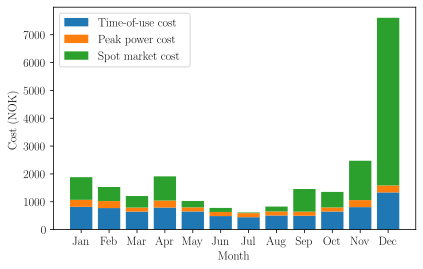

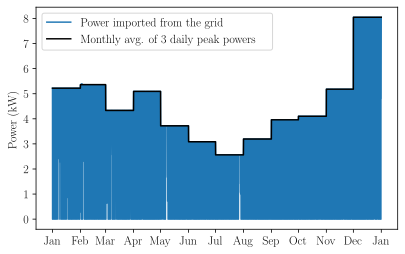

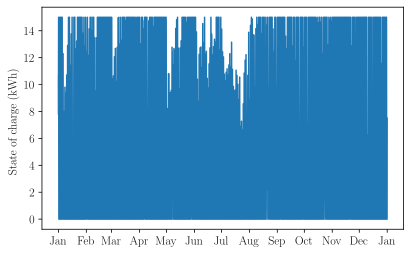

In [7]:
print_plot_and_save_costs(spot_prices, tou_prices, p.value, sim_index, "figures/monthly_costs_prescient.pdf")
plot_and_save_grid_power(sim_index, p.value, "figures/grid_power_prescient.pdf")
plot_and_save_state_of_charge(sim_index, q.value[1:], "figures/soc_prescient.pdf")
cost_prescient = compute_annual_cost(spot_prices, tou_prices, p.value, sim_index)

## Cost versus storage capacity

In [8]:
# # Define the range of storage capacities to evaluate
# storage_capacities = np.linspace(0, 100)

# # Initialize arrays for storing the costs (time-of-use and peak power)
# tou_cost_values = np.zeros(len(storage_capacities))
# spot_cost_values = np.zeros(len(storage_capacities))
# peak_power_cost_values = np.zeros(len(storage_capacities))

# # Perform sensitivity analysis for various storage capacities
# for i, capacity in tqdm.tqdm(enumerate(storage_capacities), total=len(storage_capacities), desc="Performing sensitivity analysis"):
#     # Update parameter values for the current capacity
#     Q.value = capacity
#     C.value = Q.value / 2
#     D.value = Q.value / 2
#     q_init.value = Q.value / 2
#     q_final.value = Q.value / 2
    
#     # Solve the optimization problem for the current capacity
#     problem.solve()

#     assert problem.status == cp.OPTIMAL, f"Solver failed to find an optimal solution. Problem status: {problem.status}"
    
#     # Store the results (time-of-use and peak power costs)
#     tou_cost_values[i] = tou_cost.value
#     spot_cost_values[i] = spot_cost.value
#     peak_power_cost_values[i] = peak_power_cost.value

# # Calculate the savings
# tou_savings = tou_cost_values[0] - tou_cost_values
# spot_savings = spot_cost_values[0] - spot_cost_values
# peak_power_savings = peak_power_cost_values[0] - peak_power_cost_values
# total_savings = (tou_cost_values[0] + spot_cost_values[0] + peak_power_cost_values[0]) - (tou_cost_values + spot_cost_values + peak_power_cost_values)


Performing sensitivity analysis: 100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


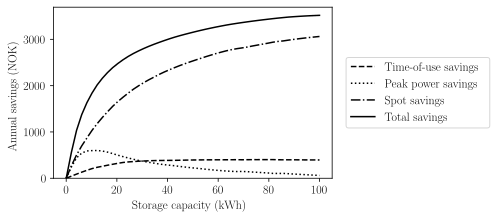

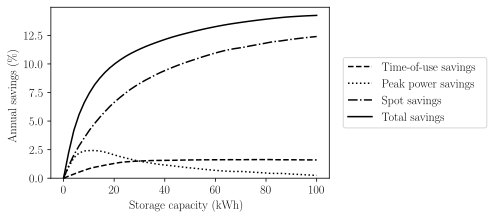

In [9]:
# # Plot the savings: time-of-use savings, peak power savings, total savings, and spot savings
# latexify(fig_width=5)
# plt.figure()
# plt.plot(storage_capacities, tou_savings, color="black", linestyle="dashed", label="Time-of-use savings")
# plt.plot(storage_capacities, peak_power_savings, color="black", linestyle="dotted", label="Peak power savings")
# plt.plot(storage_capacities, spot_savings, color="black", linestyle="dashdot", label="Spot savings")
# plt.plot(storage_capacities, total_savings, color="black", linestyle="solid", label="Total savings")
# plt.xlabel("Storage capacity (kWh)")
# plt.ylabel("Annual savings (NOK)")
# plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
# plt.ylim(bottom=0)
# plt.savefig("figures/savings_vs_storage_capacity.pdf")

# # Calculate the percentage savings
# total_cost_no_storage = tou_cost_values[0] + spot_cost_values[0] + peak_power_cost_values[0]
# tou_savings_percentage = (tou_savings / total_cost_no_storage) * 100
# spot_savings_percentage = (spot_savings / total_cost_no_storage) * 100
# peak_power_savings_percentage = (peak_power_savings / total_cost_no_storage) * 100
# total_savings_percentage = (total_savings / total_cost_no_storage) * 100

# # Plot the percentage savings: time-of-use savings, peak power savings, total savings, and spot savings
# latexify(fig_width=5)
# plt.figure()
# plt.plot(storage_capacities, tou_savings_percentage, color="black", linestyle="dashed", label="Time-of-use savings %")
# plt.plot(storage_capacities, peak_power_savings_percentage, color="black", linestyle="dotted", label="Peak power savings %")
# plt.plot(storage_capacities, spot_savings_percentage, color="black", linestyle="dashdot", label="Spot savings %")
# plt.plot(storage_capacities, total_savings_percentage, color="black", linestyle="solid", label="Total savings %")
# plt.xlabel("Storage capacity (kWh)")
# plt.ylabel("Annual savings (\%)")
# plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
# plt.ylim(bottom=0)
# plt.savefig("figures/savings_percentage_vs_storage_capacity.pdf")

## MPC with a baseline-residual forecast (15 kWh of storage capacity)

In [ ]:
def group_hours_by_day(datetime_index):
    datetime_series = pd.Series(datetime_index)
    grouped_hours = datetime_series.groupby(datetime_series.dt.to_period('D')).indices
    return grouped_hours

def calculate_peak_power_cost(p, datetime_index, a, b, z_init):
    peak_power_cost = 0
    month_indices = datetime_index.month.unique()

    for month in month_indices:
        month_mask = (pd.Series(datetime_index).dt.month == month)
        month_length = sum(month_mask)
        p_month = p[month_mask]
        month_hours = pd.Series(datetime_index)[month_mask]
        daily_hours_grouped = group_hours_by_day(month_hours)
        p_daily_max = [cp.max(p_month[hour_indices.tolist()]) for hour_indices in daily_hours_grouped.values()]
        days_in_month = len(p_daily_max)

        if days_in_month == 1:
            z = cp.max(cp.hstack(p_daily_max))
        elif days_in_month == 2:
            z = 1/2 * cp.sum_largest(cp.hstack(p_daily_max), 2)
        else:
            z = 1/3 * cp.sum_largest(cp.hstack(p_daily_max), 3)
        
    # unique_months = pd.Series(datetime_index).dt.to_period('M').nunique()
    # first_month = pd.Series(datetime_index).dt.month.min()

    # for month in range(first_month, first_month + unique_months):
    #     month_mask = (pd.Series(datetime_index).dt.month == month)
    #     month_length = sum(month_mask)
    #     p_month = p[month_mask]
    #     month_hours = pd.Series(datetime_index)[month_mask]
    #     daily_hours_grouped = group_hours_by_day(month_hours)
    #     p_daily_max = [cp.max(p_month[hour_indices.tolist()]) for hour_indices in daily_hours_grouped.values()]

    #     days_in_month = len(p_daily_max)
    #     if days_in_month == 1:
    #         z = cp.max(cp.hstack(p_daily_max))
    #     elif days_in_month == 2:
    #         z = 1/2 * cp.sum_largest(cp.hstack(p_daily_max), 2)
    #     else:
    #         z = 1/3 * cp.sum_largest(cp.hstack(p_daily_max), 3)

        peak_power_cost += a + b * cp.pos(z - z_init)

    return peak_power_cost

def run_mpc(load, tou_prices, datetime_index, q_init, z_init, T_MPC):
    p = cp.Variable(T_MPC) 
    u = cp.Variable(T_MPC) 
    q = cp.Variable(T_MPC+1)

    cons = [p >= 0, p <= P,
            load == p + u,
            q[1:] == (1 - alpha) * q[:-1] - u,
            q[0] == q_init, q[-1] == q_final, 
            q >= 0, q <= Q,
            -C <= u, u <= D]

    tou_cost = cp.sum(cp.multiply(tou_prices, p))
    peak_power_cost = calculate_peak_power_cost(p, datetime_index, a, b, z_init)
    cost = tou_cost + peak_power_cost
    problem = cp.Problem(cp.Minimize(cost), cons)
    problem.solve()

    u0, p0 = u.value[0], p.value[0]
    return u0, p0

def update_z(p_values, sim_index):
    last_month = pd.Series(sim_index).dt.to_period('M').iloc[-1]
    month_mask = (pd.Series(sim_index).dt.to_period('M') == last_month)
    p_month = p_values[month_mask]
    month_hours = pd.Series(sim_index)[month_mask]
    daily_hours_grouped = group_hours_by_day(month_hours)
    p_daily_max = [np.max(p_month[hour_indices]) for hour_indices in daily_hours_grouped.values()]

    days_in_month = len(p_daily_max)
    if days_in_month == 1:
        z = np.max(p_daily_max)
    elif days_in_month == 2:
        z = 1/2 * np.sum(np.sort(p_daily_max)[-2:])
    else:
        z = 1/3 * np.sum(np.sort(p_daily_max)[-3:])

    return z

def predict_load(load, baseline, AR_params, t, M, L):
    past = load[t-M:t]
    past_baseline = baseline[t-M:t]
    fut_baseline = baseline[t:t+L]
    pred = list(reversed(past-past_baseline)) @ AR_params
    
    pred = pd.Series(pred, index=fut_baseline.index)
    pred += fut_baseline
    pred = np.maximum(load_min, pred)
    pred = np.minimum(load_max, pred)
    return pred

def make_load_forecast(t, T_MPC, M, L):
    curr_load = np.array([load_data[sim_start_time + t]])
    baseline_AR_forecast = predict_load(load_data, load_baseline, AR_params, sim_start_time+t+1, M, L)[:-1]
    if T_MPC > L:
        baseline_forecast = load_baseline[sim_start_time+t+1+L:sim_start_time+t+T_MPC]
    else:
        baseline_forecast = np.array([])
    
    load_forecast = np.concatenate((curr_load, baseline_AR_forecast, baseline_forecast))
    return load_forecast
    

In [ ]:
# Constants
Q = 15
C, D, q_init, q_final = Q/2, Q/2, Q/2, Q/2
T_MPC = 24
M, L = 24, 24

p_values = np.zeros(T)
q_values = np.zeros(T+1)
z_values = np.zeros(T+1)

# Initial conditions
q_values[0] = q_init
z = 0

z_values = []

# MPC loop
for t in tqdm.trange(T):
    # Make forecasts
    load_forecast = make_load_forecast(t, T_MPC, M, L)
    tou_price_forecast = tou_price_data[sim_start_time+t:sim_start_time+t+T_MPC].values
    datetime_index = load_baseline.index[sim_start_time+t:sim_start_time+t+T_MPC]
    
    # Make a plan optimizing over a time horizon
    u, p = run_mpc(load_forecast, tou_price_forecast, datetime_index, q_values[t], z, T_MPC)

    # Execute first action from that plan
    p_values[t] = p
    q_values[t+1] = (1 - alpha) * q_values[t] - u
    if load_baseline.index[t].month == load_baseline.index[t+1].month:
        z = update_z(p_values[:t+1], sim_index[:t+1])
    else:
        z = 0
        
    z_values.append(z)

In [ ]:
plt.plot(sim_index, z_values)

In [ ]:
# # Constants
# Q = 15
# C, D, q_init, q_final = Q/2, Q/2, Q/2, Q/2
# T_MPC = 24
# M, L = 24, 24

# t = T-23

# print(sim_index[t])

# # Make forecasts
# load_forecast = make_load_forecast(t, T_MPC, M, L)
# tou_price_forecast = tou_price_data[sim_start_time+t:sim_start_time+t+T_MPC].values
# datetime_index = load_baseline.index[sim_start_time+t:sim_start_time+t+T_MPC]

# # MPC code
# p = cp.Variable(T_MPC) 
# u = cp.Variable(T_MPC) 
# q = cp.Variable(T_MPC+1)

# cons = [p >= 0, p <= P,
#         load_forecast == p + u,
#         q[1:] == (1 - alpha) * q[:-1] - u,
#         q[0] == q_init, q[-1] == q_final, 
#         q >= 0, q <= Q,
#         -C <= u, u <= D]

# tou_cost = cp.sum(cp.multiply(tou_price_forecast , p))
    
# # Calculate peak cost

# print(datetime_index)

# # Extract month indices 
# month_indices = datetime_index.month.unique()
# print(f"month_indices: {month_indices}")

# for month in month_indices:
#     print(f"Processing month {month}")
    
#     month_mask = (pd.Series(datetime_index).dt.month == month)
#     print(f"month_mask: {month_mask}")
    
#     month_length = sum(month_mask)
#     print(f"month_length: {month_length}")
    
#     p_month = p[month_mask]
#     print(f"p_month: {p_month}")
    
#     month_hours = pd.Series(datetime_index)[month_mask]
#     print(f"month_hours: {month_hours}")
    
#     daily_hours_grouped = group_hours_by_day(month_hours)
#     print(f"daily_hours_grouped: {daily_hours_grouped}")
    
#     p_daily_max = [cp.max(p_month[hour_indices.tolist()]) for hour_indices in daily_hours_grouped.values()]
#     print(f"p_daily_max: {p_daily_max}")

#     days_in_month = len(p_daily_max)
#     print(f"days_in_month: {days_in_month}")
    
#     if days_in_month == 1:
#         z = cp.max(cp.hstack(p_daily_max))
#     elif days_in_month == 2:
#         z = 1/2 * cp.sum_largest(cp.hstack(p_daily_max), 2)
#     else:
#         z = 1/3 * cp.sum_largest(cp.hstack(p_daily_max), 3)
    
#     print(f"z: {z}")
    
    
    

# month_indices = datetime_index.month.unique()

# for month in month_indices:
#     month_mask = (pd.Series(datetime_index).dt.month == month)
#     month_length = sum(month_mask)
#     p_month = p[month_mask]
#     month_hours = pd.Series(datetime_index)[month_mask]
#     daily_hours_grouped = group_hours_by_day(month_hours)
#     p_daily_max = [cp.max(p_month[hour_indices.tolist()]) for hour_indices in daily_hours_grouped.values()]
#     days_in_month = len(p_daily_max)

#     if days_in_month == 1:
#         z = cp.max(cp.hstack(p_daily_max))
#     elif days_in_month == 2:
#         z = 1/2 * cp.sum_largest(cp.hstack(p_daily_max), 2)
#     else:
#         z = 1/3 * cp.sum_largest(cp.hstack(p_daily_max), 3)

    








In [ ]:
# Calculate the time-of-use cost per month
monthly_tou_cost = compute_monthly_tou_cost(tou_prices, p_values, sim_index)

# Calculate the peak power cost per month
monthly_peak_power_cost = compute_monthly_peak_power_cost(p_values, sim_index, a, b)

# Calculate total costs for each category
total_cost = sum(monthly_tou_cost) + sum(monthly_peak_power_cost)
total_tou_cost = sum(monthly_tou_cost)
total_peak_power_cost = sum(monthly_peak_power_cost)

# Calculate the monthly average of the three largest daily peak powers
z_values = compute_monthly_avg_largest_3_daily_peak_powers(p_values, sim_index)

# Create a grid power plot
plot_grid_power(sim_index, p_values, z_values, "Power (kW)", "figures/linear_power_mpc.pdf")

# Create a state of charge plot
plot_state_of_charge(sim_index, q_values[1:], "State of charge (kWh)", "figures/linear_soc_mpc.pdf")

# Display cost summary
print_cost_summary(total_cost, total_tou_cost, total_peak_power_cost)

# Create a stack plot showing monthly time-of-use and peak power costs
plot_monthly_costs(monthly_tou_cost, monthly_peak_power_cost, "figures/linear_cost_mpc.pdf")

cost_mpc = total_cost

## Cost comparison

In [ ]:
relative_gap = (abs(cost_mpc - cost_prescient) / abs(cost_prescient)) * 100

print(f"Cost without storage (upper bound): {cost_no_storage:,.2f} NOK")
print(f"MPC cost: {cost_mpc:,.2f} NOK")
print(f"Prescient cost (lower bound): {cost_prescient:,.2f} NOK")
print(f"Relative gap between MPC cost and prescient cost: {relative_gap:.2f}%")
